- Model Selection

In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import sqlite3

In [13]:
df = pd.read_excel('들_1,2,3_0.xlsx')

- KNN, Logistic

In [346]:
pipe1 = Pipeline([('mm',MinMaxScaler())])
pipe2 = Pipeline([('ss',StandardScaler())])
ct1 = ColumnTransformer([('mm', pipe1, ['left_branching_entropy','right_branching_entropy','left_accessor_variety','right_accessor_variety','leftside_frequency','rightside_frequency'])])
ct2 = ColumnTransformer([('ss', pipe2, ['left_branching_entropy','right_branching_entropy','left_accessor_variety','right_accessor_variety','leftside_frequency','rightside_frequency'])])

In [347]:
pipe1 = Pipeline([('mm',MinMaxScaler())])
pipe2 = Pipeline([('ss',StandardScaler())])
ct1 = ColumnTransformer([('mm', pipe1, ['left_branching_entropy','right_branching_entropy','left_accessor_variety','right_accessor_variety','leftside_frequency','rightside_frequency'])])
ct2 = ColumnTransformer([('ss', pipe2, ['left_branching_entropy','right_branching_entropy','left_accessor_variety','right_accessor_variety','leftside_frequency','rightside_frequency'])])
final_pipe1 = Pipeline([('ct',ct1),('clf',KNeighborsClassifier())])
final_pipe2 = Pipeline([('ct',ct2),('clf',KNeighborsClassifier())])
ns_pipe = Pipeline([('clf',KNeighborsClassifier())])
grid1 = GridSearchCV(final_pipe1, [{'clf':[KNeighborsClassifier()], 'clf__n_neighbors':range(2,8)},
                          {'clf':[LogisticRegression()], 'clf__penalty':['l1','l2'],'clf__C':[0.1,1,10,100,1000], 'clf__solver':['liblinear','sag','saga','lbfgs']}])
grid2 = GridSearchCV(final_pipe2, [{'clf':[KNeighborsClassifier()], 'clf__n_neighbors':range(2,8)},
                          {'clf':[LogisticRegression()], 'clf__penalty':['l1','l2'],'clf__C':[0.1,1,10,100,1000], 'clf__solver':['liblinear','sag','saga','lbfgs']}])
grid3 = GridSearchCV(ns_pipe, [{'clf':[KNeighborsClassifier()], 'clf__n_neighbors':range(2,8)},
                          {'clf':[LogisticRegression()], 'clf__penalty':['l1','l2'],'clf__C':[0.1,1,10,100,1000], 'clf__solver':['liblinear','sag','saga','lbfgs']}])

In [348]:
grid1.fit(df.iloc[:,3:], df.iloc[:,2])
temp1 = pd.DataFrame(grid1.cv_results_).T
temp1.to_excel('mm_들_1,2,3_0.xlsx')
grid2.fit(df.iloc[:,3:], df.iloc[:,2])
temp2 = pd.DataFrame(grid2.cv_results_).T
temp2.to_excel('ss_들_1,2,3_0.xlsx')
grid3.fit(df.iloc[:,3:], df.iloc[:,2])
temp3 = pd.DataFrame(grid3.cv_results_).T
temp3.to_excel('ns_들_1,2,3_0.xlsx')

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklear

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklear

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\s

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gozj3\anaconda3\lib\site-packages\s

In [349]:
grid3.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [350]:
pipe = Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,3:],df.iloc[:,2])

In [352]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [353]:
y_pred = pipe.predict(X_test)

In [354]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y_test,y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.6169154228855722, 0.5904761904761905, 0.6438482886216467)

In [355]:
confusion_matrix(y_test,y_pred)

array([[386, 170],
       [215, 310]], dtype=int64)

- DecisionTree

In [53]:
ns_pipe = Pipeline([('clf',DecisionTreeClassifier())])
grid = GridSearchCV(ns_pipe, [{'clf':[DecisionTreeClassifier()], 'clf__criterion':['gini','entropy'], 'clf__max_depth':range(4,20), 'clf__min_samples_split':range(2,6), 'clf__min_samples_leaf':range(2,4), 'clf__random_state':[0,13]}])

In [54]:
grid.fit(df.iloc[:,3:], df.iloc[:,2])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                      

In [55]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=4,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=13,
                                        splitter='best'))],
         verbose=False)

In [45]:
pipe = Pipeline(memory=None,
         steps=[('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=4,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=13,
                                        splitter='best'))],
         verbose=False)

In [46]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=4,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=13,
                                        splitter='best'))],
         verbose=False)

In [47]:
y_pred = pipe.predict(X_test)

In [48]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y_test,y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.514018691588785, 0.45454545454545453, 0.7113783533765032)

- RandomForest

In [51]:
ns_pipe = Pipeline([('clf',RandomForestClassifier())])
grid = GridSearchCV(ns_pipe, [{'clf':[RandomForestClassifier()], 'clf__n_estimators':[100,200,300], 'clf__max_depth':[3,5,7,9], 'clf__min_samples_leaf':[2,3,5,7,9], 'clf__min_samples_split':[3,5,7,9], 'clf__random_state':[0,13]}])

In [52]:
grid.fit(df.iloc[:,3:], df.iloc[:,2])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                           

In [53]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=7, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [54]:
pipe =Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=7, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [55]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=7, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [56]:
y_pred = pipe.predict(X_test)

In [57]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y_test,y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.493006993006993, 0.3884297520661157, 0.7317298797409806)

In [58]:
confusion_matrix(y_test, y_pred)

array([[650,  68],
       [222, 141]], dtype=int64)

- XGBoosting

In [15]:
from xgboost import XGBClassifier

In [26]:
ns_pipe = Pipeline([('clf',XGBClassifier())])
grid = GridSearchCV(ns_pipe, [{'clf':[XGBClassifier()], 'clf__max_depth':[3,5,7,9],'clf__n_estimators':[100,500,1000], 'clf__learning_rate':[0.05,0.1,0.15,0.2], 'clf__booster':['gbtree','gblinear'], 'clf__subsample':[0.6,0.8,1.0], 'clf__random_state':[0,13]}])

In [27]:
grid.fit(df.iloc[:,3:], df.iloc[:,2])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                                                      n_estimators=100,
               

In [28]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=13,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.8,
                               verbosity=1))],
         verbose=False)

In [35]:
pipe = Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=13,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.8,
                               verbosity=1))],
         verbose=False)

In [36]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=13,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.8,
                               verbosity=1))],
         verbose=False)

In [37]:
y_pred = pipe.predict(X_test)

In [38]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y_test,y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.4991568296795953, 0.40771349862258954, 0.7252543940795559)

In [39]:
confusion_matrix(y_test, y_pred)

array([[636,  82],
       [215, 148]], dtype=int64)

- XGBoosting, RandomForest
    - 들,2,3_0 / 들_1,2,3_0

In [2]:
df1 = pd.read_excel('들,2,3_0.xlsx')
df2 = pd.read_excel('들_1,2,3_0.xlsx')

In [3]:
ns_pipe = Pipeline([('clf',RandomForestClassifier())])
grid1 = GridSearchCV(ns_pipe, [{'clf':[RandomForestClassifier()], 'clf__n_estimators':[100,200,300], 'clf__max_depth':[3,5,7,9], 'clf__min_samples_leaf':[2,3,5,7,9], 'clf__min_samples_split':[3,5,7,9], 'clf__random_state':[0,13]},
                             {'clf':[XGBClassifier()], 'clf__max_depth':[3,5,7,9],'clf__n_estimators':[100,500,1000], 'clf__learning_rate':[0.05,0.1,0.15,0.2], 'clf__booster':['gbtree','gblinear'], 'clf__subsample':[0.6,0.8,1.0], 'clf__random_state':[0,13]}])
grid2 = GridSearchCV(ns_pipe, [{'clf':[RandomForestClassifier()], 'clf__n_estimators':[100,200,300], 'clf__max_depth':[3,5,7,9], 'clf__min_samples_leaf':[2,3,5,7,9], 'clf__min_samples_split':[3,5,7,9], 'clf__random_state':[0,13]},
                             {'clf':[XGBClassifier()], 'clf__max_depth':[3,5,7,9],'clf__n_estimators':[100,500,1000], 'clf__learning_rate':[0.05,0.1,0.15,0.2], 'clf__booster':['gbtree','gblinear'], 'clf__subsample':[0.6,0.8,1.0], 'clf__random_state':[0,13]}])

In [4]:
grid1.fit(df1.iloc[:,3:], df1.iloc[:,2])
temp1 = pd.DataFrame(grid1.cv_results_).T
temp1.to_excel('xg,rf_들,2,3_0.xlsx')
grid2.fit(df2.iloc[:,3:], df2.iloc[:,2])
temp2 = pd.DataFrame(grid2.cv_results_).T
temp2.to_excel('xg,rf_들_1,2,3_0.xlsx')

XGBClassifier(n_estimators=100,random_state=0, booster='gbtree',learning_rate=0.1,subsample=0.8)
100
0
gbtree
0.1
0.8


In [5]:
grid1.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [6]:
grid2.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=13,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.8,
                               verbosity=1))],
         verbose=False)

In [61]:
pipe1 = Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

pipe2 = Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=13,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.8,
                               verbosity=1))],
         verbose=False)

In [65]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df1.iloc[:,3:],df1.iloc[:,2], stratify=df1.iloc[:,2])
# X2_train, X2_test, y2_train, y2_test = train_test_split(df2.iloc[:,3:],df2.iloc[:,2])

In [66]:
pipe1.fit(X1_train, y1_train)
# pipe2.fit(X2_train, y2_train)
y1_pred = pipe1.predict(X1_test)
# y2_pred = pipe2.predict(X2_test)

In [67]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y1_test,y1_pred), recall_score(y1_test, y1_pred), accuracy_score(y1_test, y1_pred)

(0.5132382892057026, 0.39622641509433965, 0.7789084181313598)

In [11]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y2_test,y2_pred), recall_score(y2_test, y2_pred), accuracy_score(y2_test, y2_pred)

(0.458041958041958, 0.3700564971751412, 0.7132284921369103)

- Feature Selection (RFE)

In [12]:
from sklearn.feature_selection import RFE

In [22]:
rfe = RFE(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))

In [23]:
rfe.fit(X1_train, y1_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=9, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=2, min_samples_split=3,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=200, n_jobs=None,
                                     oob_score=False, random_state=0, verbose=0,
                                     warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [24]:
y1_pred = rfe.predict(X1_test)

In [25]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y1_test,y1_pred), recall_score(y1_test, y1_pred), accuracy_score(y1_test, y1_pred)

(0.5709090909090909, 0.47865853658536583, 0.7816836262719704)

In [18]:
rfe = XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=13,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.8,
                               verbosity=1)

In [19]:
rfe.fit(X2_train, y2_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [20]:
y2_pred = rfe.predict(X2_test)

In [21]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
f1_score(y2_test,y2_pred), recall_score(y2_test, y2_pred), accuracy_score(y2_test, y2_pred)

(0.458041958041958, 0.3700564971751412, 0.7132284921369103)

- Learning Curve for final model

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score mean'>

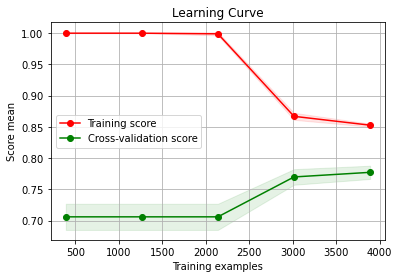

In [68]:
from sklearn.model_selection import learning_curve
import sklearn_evaluation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
train_size, train_score, test_score = learning_curve(RFE(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False)), df1.iloc[:,3:], df1.iloc[:,2], cv = kfold)
sklearn_evaluation.plot.learning_curve(train_score, test_score, train_size)